## Advanced Lane Finding

### Project 3 of the Udacity Self-Driving Car Nanodegree program

Check [**Rubric**](https://review.udacity.com/#!/rubrics/571/view) for passing prerequisites

In [2]:
# import needed libraries
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
# %matplotlib qt

**1.0 Camera Calibration**

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [ ]:
# %% Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
# read calibration images from folder
images = glob.glob('camera_cal/calibration*.jpg')

# object points in x and y direction
nx = 9
ny = 6

# prepare holders for object point and image points
objpoints = [] # 3D in real world space
imgpoints = [] # 2D points in image plane

# generate coodinates for object points
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
#         print('Points found for: ',fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
#         #cv2.imwrite(write_name, img)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)
else:
    # save image size
    img_size = gray.shape[::-1]
    plt.imshow(img)
    plt.title('Sample Calibration Image')

# Do camera calibration using object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                   img_size[:2],None,None)
np.savetxt('cam_mtx.txt', mtx)
np.savetxt('cam_dist.txt', dist)

Apply a distortion correction to raw images

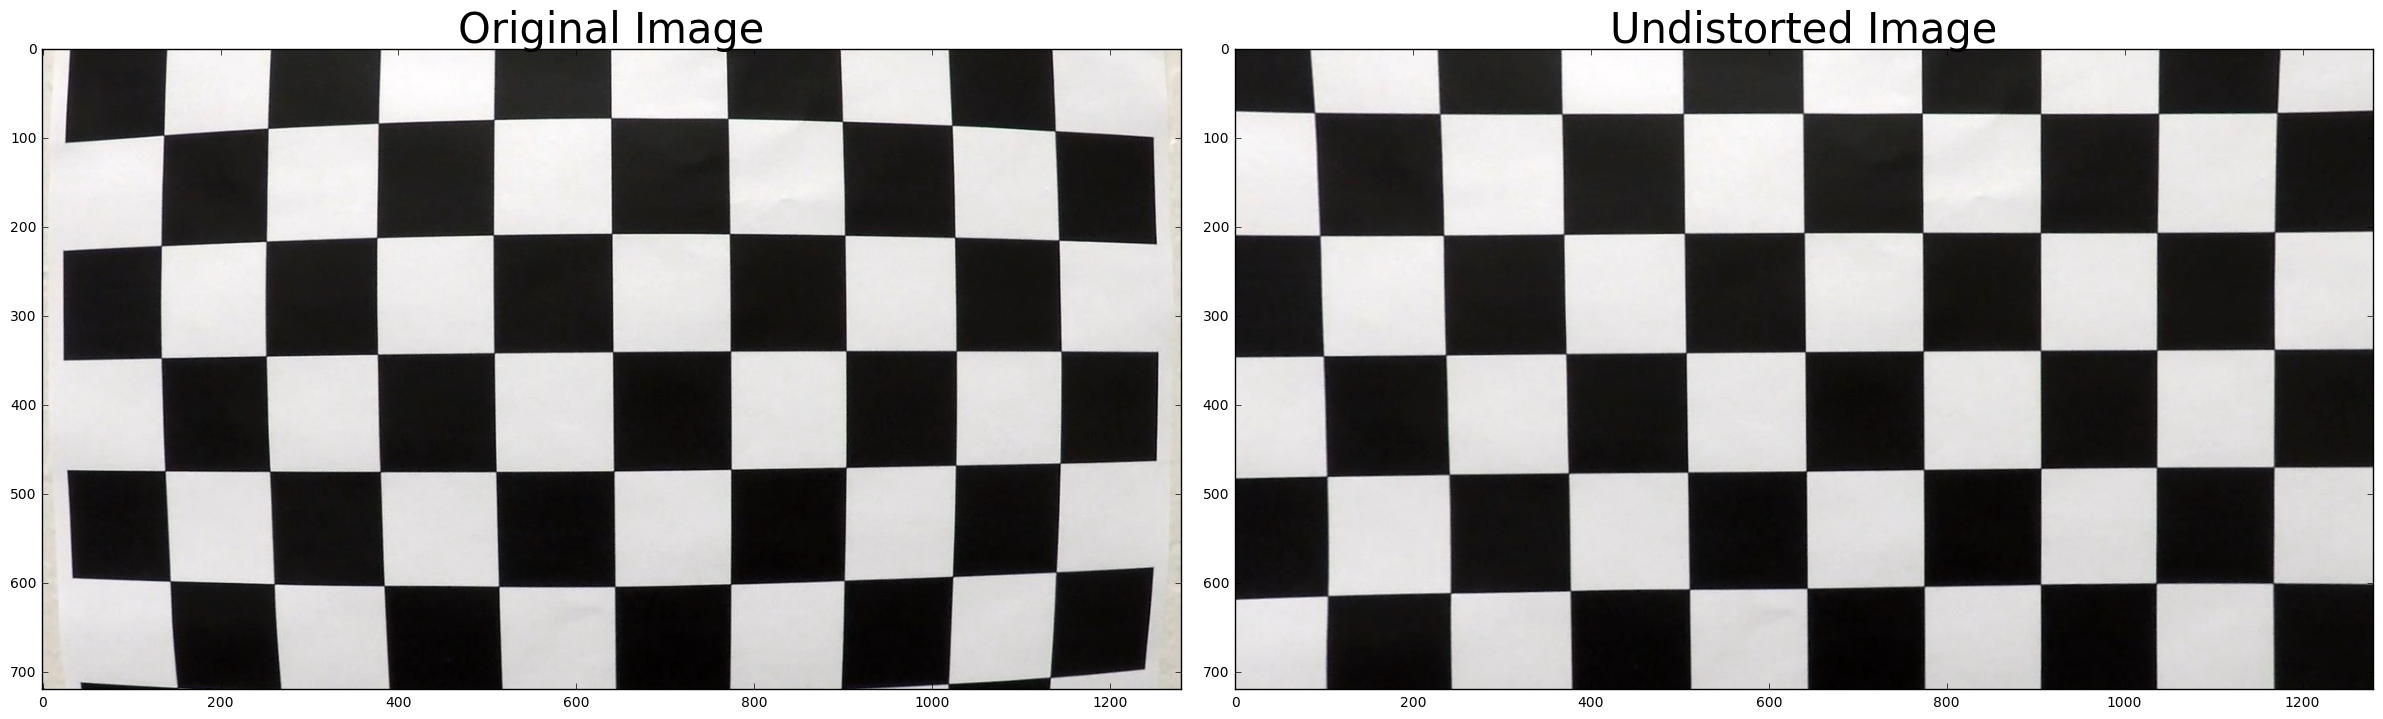

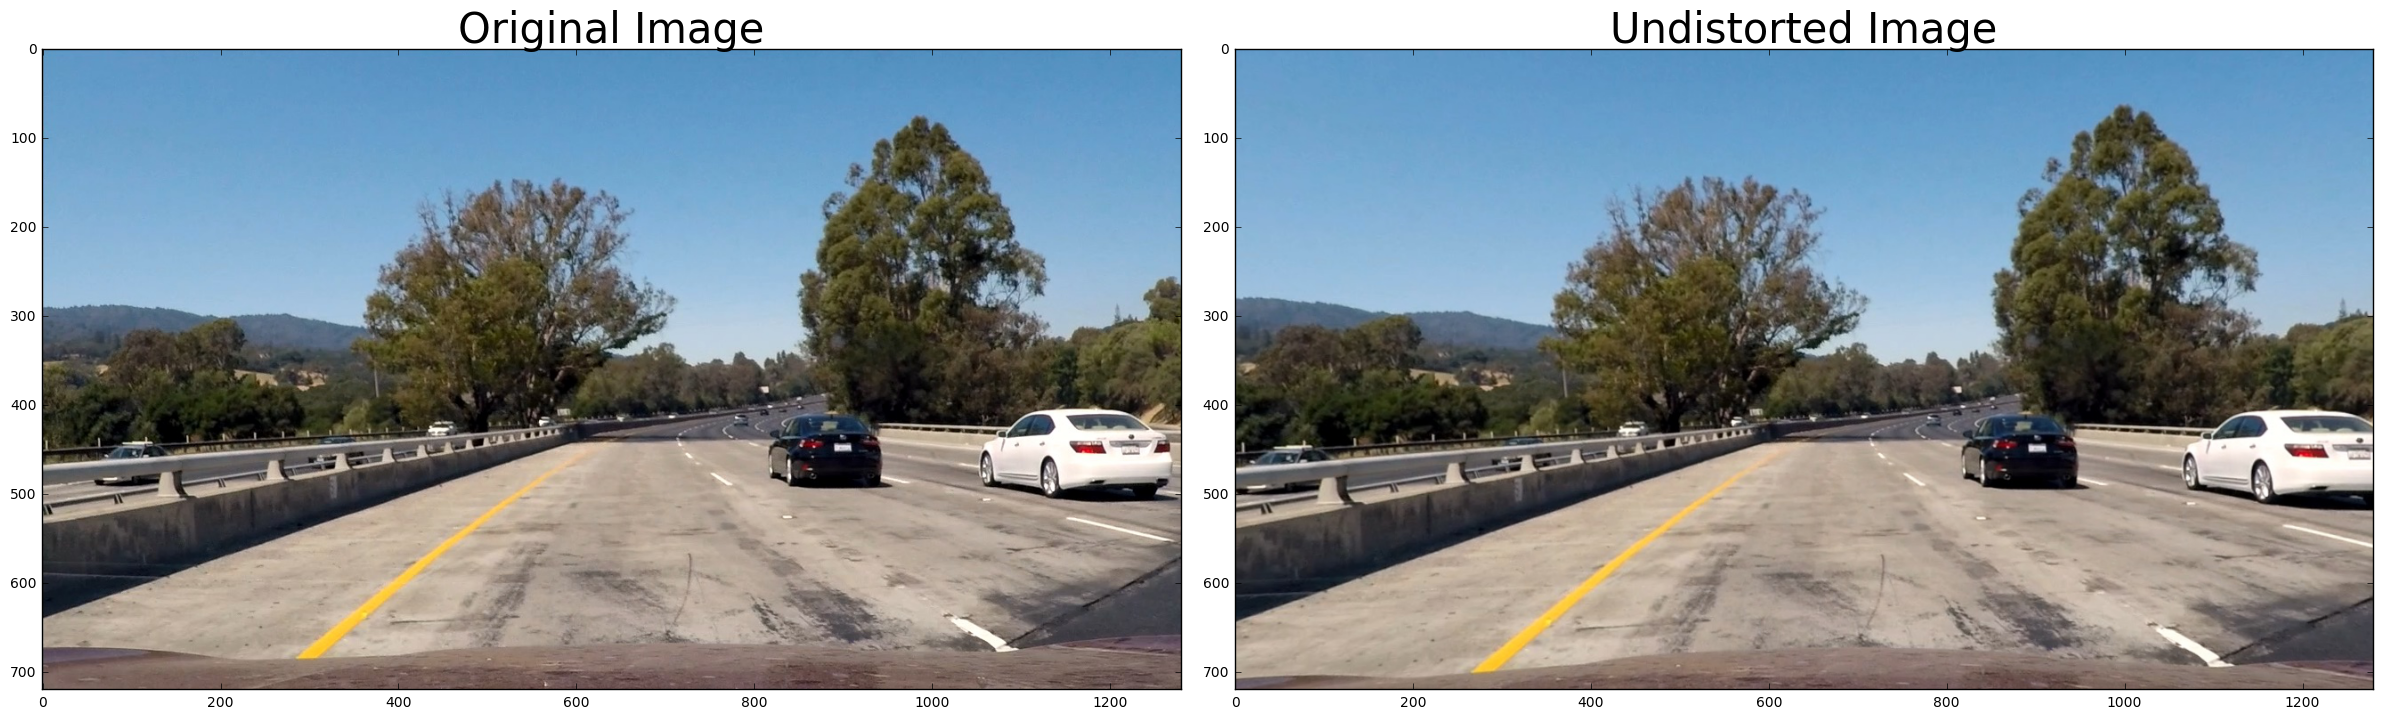

In [58]:
# %% Apply a distortion correction to raw images

mtx = np.loadtxt('cam_mtx.txt')
dist = np.loadtxt('cam_dist.txt')

# load sample image 1
img1 = mpimg.imread('camera_cal/calibration1.jpg')

# load sample image 2
img2 = mpimg.imread('test_images/test1.jpg')

# undistort images
undist1 = cv2.undistort(img1, mtx, dist, None, mtx)
undist2 = cv2.undistort(img2, mtx, dist, None, mtx)

# display results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) # 
f.tight_layout()

ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist1)
ax2.set_title('Undistorted Image', fontsize=30)
# f.savefig('output_images/undistort_result1.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) # 
f.tight_layout()

ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist2)
ax2.set_title('Undistorted Image', fontsize=30)
# f.savefig('output_images/undistort_result2.jpg')

In [ ]:
%matplotlib inline
def col_bal(gray):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    return gray
img = mpimg.imread('test_images/test4.jpg')
r_channel = img[:,:,0]
g_channel = img[:,:,1]
b_channel = img[:,:,2]


frame = np.copy(g_channel)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(frame, cmap='gray')
ax1.set_title('uncorrected', fontsize=20)
ax2.imshow(col_bal(frame), cmap='gray')
ax2.set_title('contrast corrected', fontsize=20)

**2.0 Image Thresholding**

Use colour transforms, gradient, etc, to create a threshold binary image

In [ ]:
# sample visualization of how lane lines are displayed in colour channels
img = mpimg.imread('test_images/test4.jpg')
# for rgb colour space
r_channel = img[:,:,0]
g_channel = img[:,:,1]
b_channel = img[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(r_channel, cmap='gray')
ax1.set_title('R Channel', fontsize=20)
ax2.imshow(g_channel, cmap='gray')
ax2.set_title('G Channel', fontsize=20)
ax3.imshow(b_channel, cmap='gray')
ax3.set_title('B Channel', fontsize=20)
# f.savefig('output_images/rgb_colourspace')

# for hls colour space
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(h_channel, cmap='gray')
ax1.set_title('H Channel', fontsize=20)
ax2.imshow(l_channel, cmap='gray')
ax2.set_title('L Channel', fontsize=20)
ax3.imshow(s_channel, cmap='gray')
ax3.set_title('S Channel', fontsize=20)
# f.savefig('output_images/hls_colourspace')

In [28]:
# %% Use colour transforms, gradient, etc, to create a threshold binary image
# pipeline to combine colour thresholding and gradient thresholding on image

# functions used in implementation
def bin_image(image):
    """
    convert colour binary image into a single channel binary image
    image: array with 3 channels
    return binary image with 1 channel which is a bitwise or operation of the original colour channels
    """
    binary = np.zeros_like(image[:,:,1])
    binary[(image[:,:,0] == 1) | (image[:,:,1]==1) |(image[:,:,2]==1)] = 1
    return binary

# region of interest function
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def thresh_bin_im(img):
    """
    Return the colour thresholds binary for L, S and R channels in an image
    img: RGB image
    """    
    s_thresh = [170, 255]
    sx_thresh = [25, 200]
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    r_channel = img[:,:,0]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # sobel x on r channel
    sobelx_r = cv2.Sobel(r_channel, cv2.CV_64F, 1, 0)
    abs_sobelx_r = np.absolute(sobelx_r)
    scaled_sxr = np.uint8(255*abs_sobelx_r/np.max(abs_sobelx_r))

    sxrbinary = np.zeros_like(scaled_sxr)
    sxrbinary[(scaled_sxr >= sx_thresh[0]) & (scaled_sxr <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    empty = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((sxbinary, empty, empty))

    return color_binary

def bin_it(image, threshold):
    """
    converts a single channeled image to a binary image,
    using upper and lower threshold
    """
    assert len(image.shape) == 2, 'Image received has more than one channel'
    
    output_bin = np.zeros_like(image)
    output_bin[(image >= threshold[0]) & (image <= threshold[1])]=1
    return output_bin

def threshold_colours(image):
    """
    Return binary image from thresholding colour channels
    img: RGB image
    """
    # convert image to hls colour space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # binary threshold values
    bin_thresh = [20, 255]
    
    # rgb thresholding for yellow
    lower = np.array([230,180,20],dtype = "uint8")
    upper = np.array([255, 255, 255],dtype = "uint8")
    mask = cv2.inRange(image, lower, upper)
    rgb_y = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8)
    rgb_y = cv2.cvtColor(rgb_y, cv2.COLOR_RGB2GRAY)
    rgb_y = bin_it(rgb_y, bin_thresh)
    
    
    # rgb thresholding for white (best)
    lower = np.array([100,100,190],dtype = "uint8")
    upper = np.array([255, 255, 255],dtype = "uint8")
    mask = cv2.inRange(image, lower, upper)
    rgb_w = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8)
    rgb_w = cv2.cvtColor(rgb_w, cv2.COLOR_RGB2GRAY)
    rgb_w = bin_it(rgb_w, bin_thresh)
    
    
    # hls thresholding for yellow
    lower = np.array([20,100,30],dtype = "uint8")
    upper = np.array([45, 200, 255],dtype = "uint8")
    mask = cv2.inRange(hls, lower, upper)
    hls_y = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8)
    hls_y = cv2.cvtColor(hls_y, cv2.COLOR_HLS2RGB)
    hls_y = cv2.cvtColor(hls_y, cv2.COLOR_RGB2GRAY)
    hls_y = bin_it(hls_y, bin_thresh)
    
    im_bin = np.zeros_like(hls_y)
    im_bin [(hls_y == 1)|(rgb_y==1)|(rgb_w==1)]= 1
    
    return im_bin

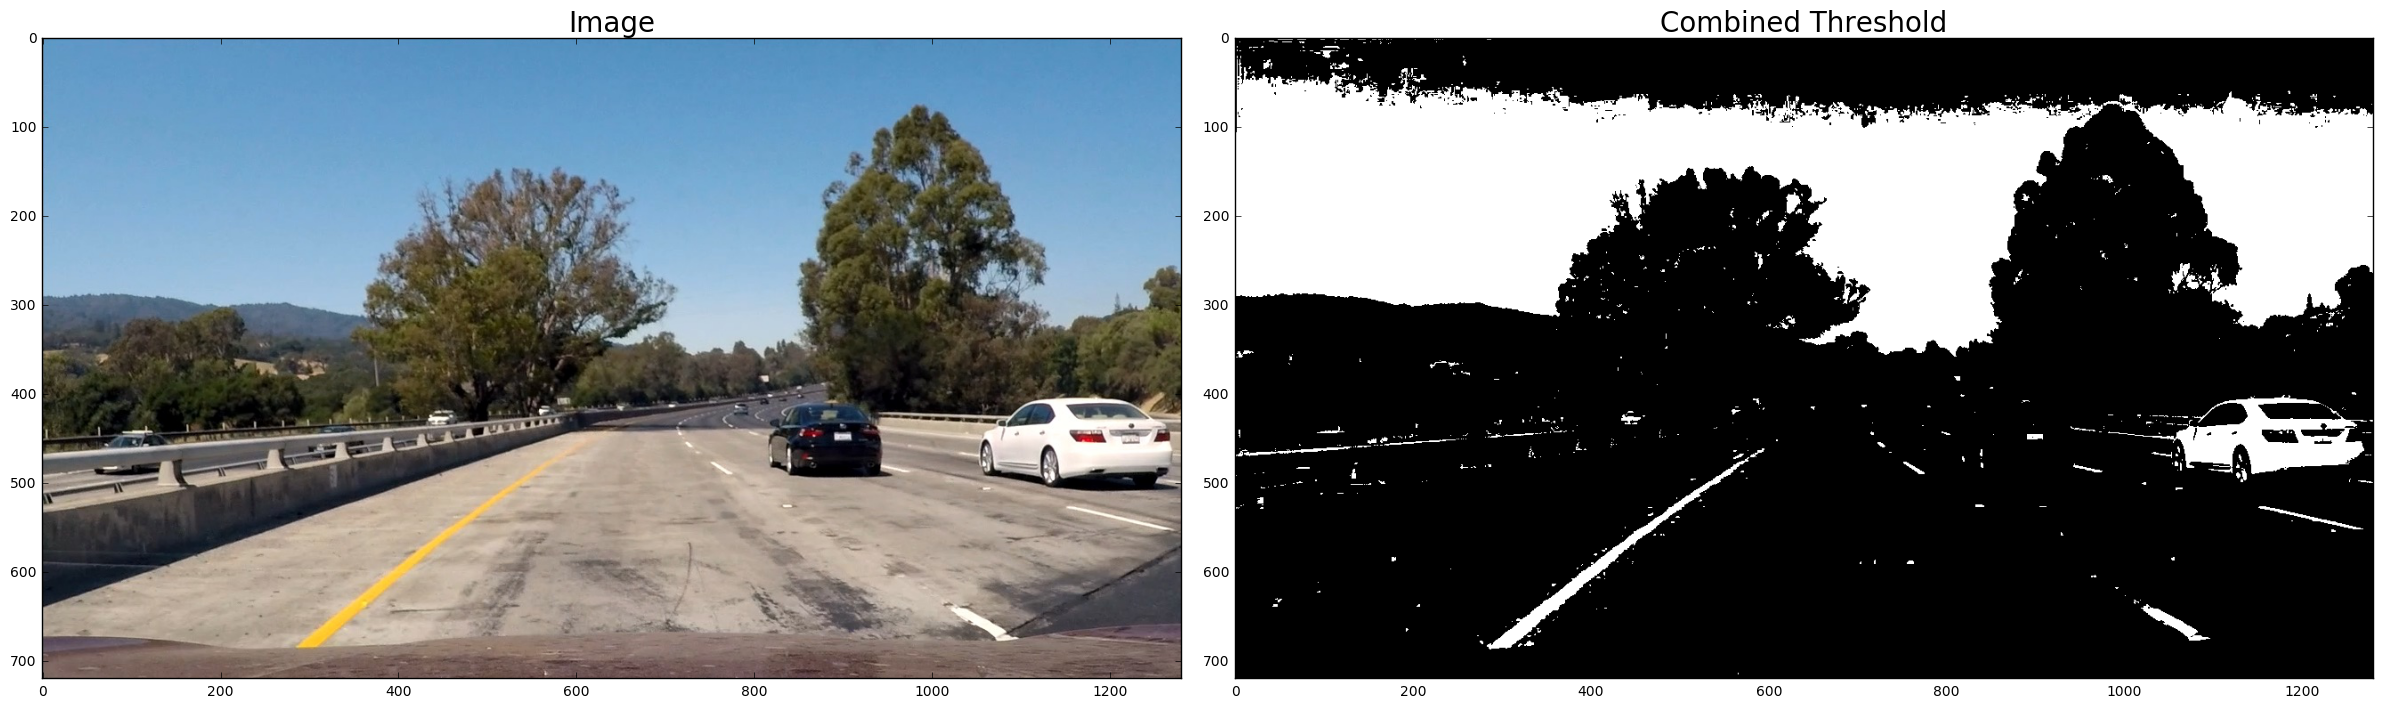

In [29]:
# %matplotlib inline
img = mpimg.imread('test_images/test1.jpg')
c_binary = threshold_colours(img)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img, cmap='gray')
ax1.set_title('Image', fontsize=20)
ax2.imshow(c_binary, cmap='gray')
ax2.set_title('Combined Threshold', fontsize=20)
# f.title('Colour Treshold on Image')
# f.savefig('output_images/combined_threshold')

**3. Perspective Transform**

Apply a perspective transform to rectify binary image ("birds-eye view")

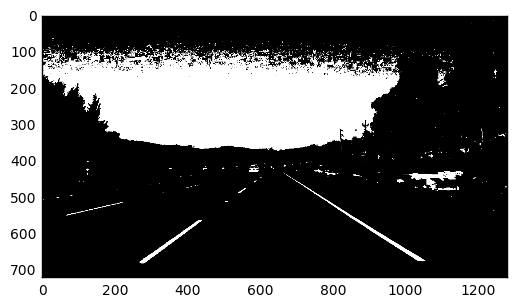

In [31]:
# %% Apply a perspective transform to rectify binary image ("birds-eye view")
# %matplotlib qt # uncomment to show output in a separate window

# load a straight line image to determine road planes
img = mpimg.imread('test_images/straight_lines2.jpg')

# apply colour transformation
color_binary = threshold_colours(img)
output = color_binary.astype(np.int8) # without this line, the output is a total black image

plt.imshow(output, cmap='gray')

In [64]:
# Compute the perspective transform, M, given source and destination points:
# here we manually pick points on the image that corresponds to the plane of the road in other to use it to warp the image to a bird's eye view

src_points = np.float32([[270,674],
                         [587,455],
                         [694,455],
                         [1035,674]])
dst_points = np.float32([[270,674],
                         [270,0],
                         [1035,0],
                         [1035,674]])

# alternative points
# src_points = np.float32([[275,673],
#                          [595,449],
#                          [686,449],
#                          [1035,673]])
# dst_points = np.float32([[275,673],
#                          [275,0],
#                          [1035,0],
#                          [1035,673]])

# obtain perspective transform parameters
M = cv2.getPerspectiveTransform(src_points, dst_points)
Minv = cv2.getPerspectiveTransform(dst_points, src_points)

np.savetxt('M_mat.txt', M)
np.savetxt('Minv_mat.txt', Minv)

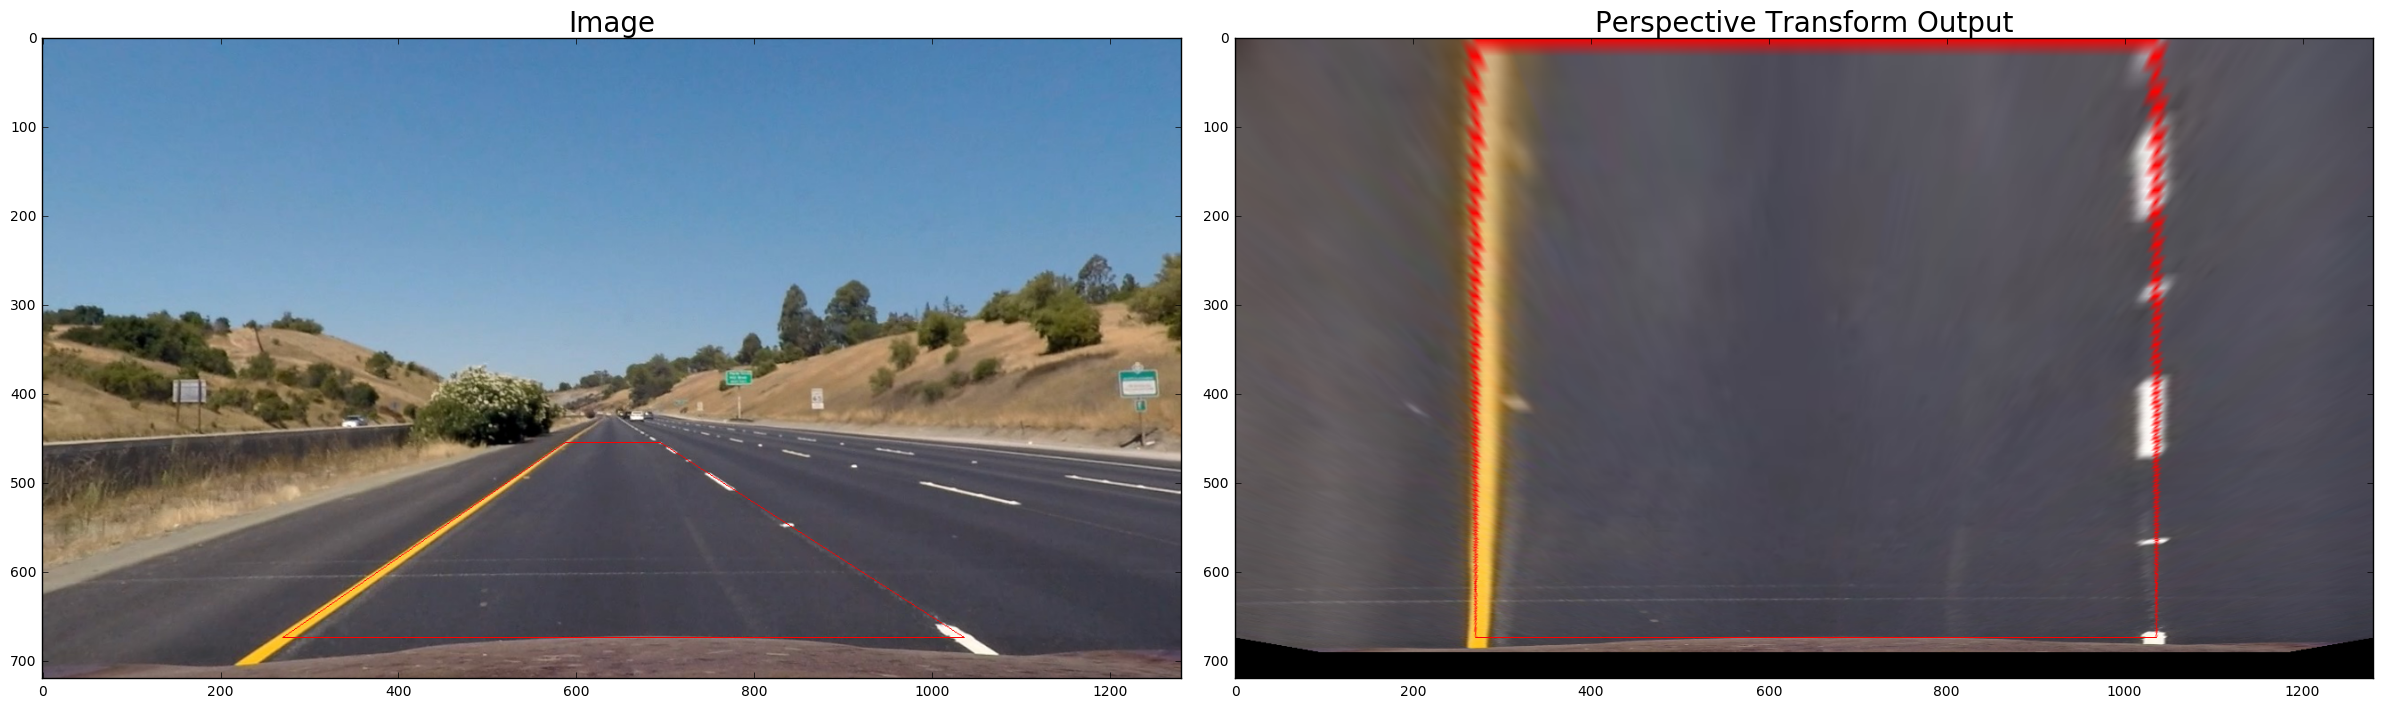

In [68]:
# verify transformation by projecting points on image and warping to see if they are parallel
%matplotlib inline
test_im = mpimg.imread('test_images/straight_lines1.jpg')

# correct distortion
test_im = cv2.undistort(test_im, mtx, dist, None, mtx)
pts = src_points.astype(np.int32)
drawn = cv2.polylines(test_im, [pts],True, (255, 0, 0))
img_size = drawn.shape[:2][::-1]
warped = cv2.warpPerspective(drawn, M, img_size, flags=cv2.INTER_LINEAR)

# plt.imshow(drawn)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_im, cmap='gray')
ax1.set_title('Image', fontsize=20)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Perspective Transform Output', fontsize=20)
# plt.title('Perspective Transform Output')
# plt.savefig('output_images/warp_verify')

In [73]:
def transform_n_warp(image, M):
    """
    apply transforms to image and warp the image according to transformation matrix
    image: image to be transformed
    M: transformation matrix
    """
    # image size
    img_size = image.shape[:2][::-1]
    
    
    
    # warp image
    image = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    # convert to coloured binary image
    image = threshold_colours(image)

    return image

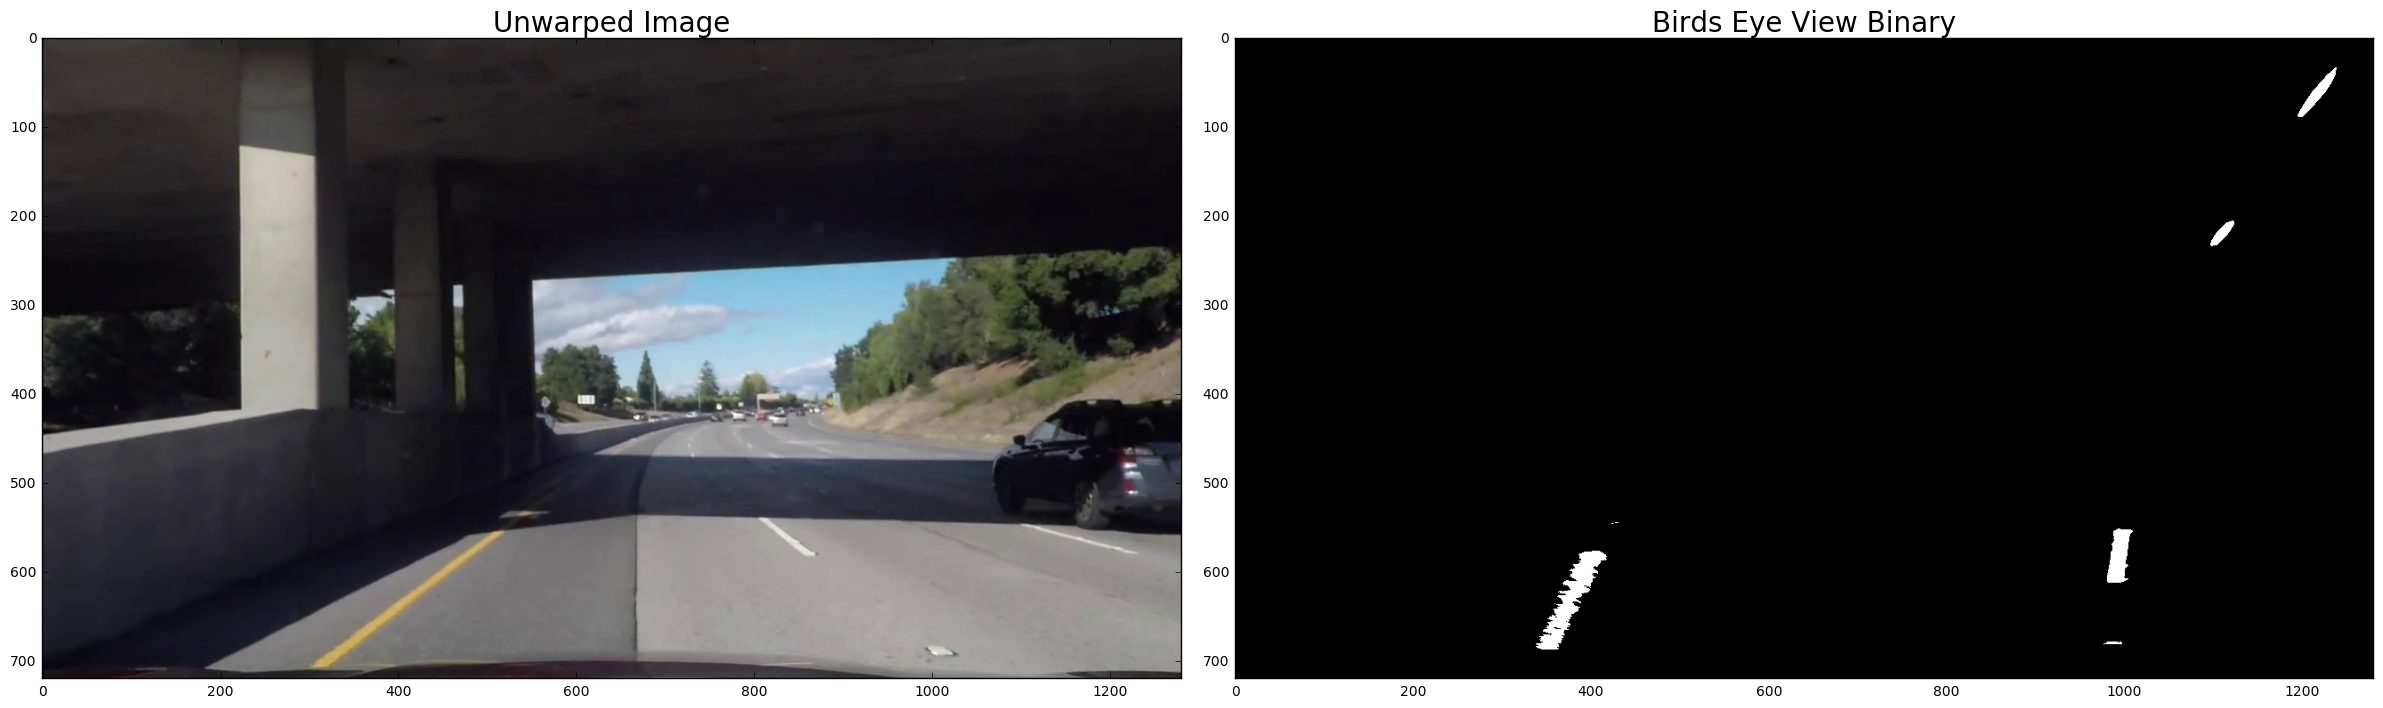

In [76]:
# test pipeline on an image
test_im = mpimg.imread('test_images/test8.jpg')
test_im = cv2.undistort(test_im, mtx, dist, None, mtx)
warped = transform_n_warp(test_im, M)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_im, cmap='gray')
ax1.set_title('Unwarped Image', fontsize=20)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Birds Eye View Binary', fontsize=20)
# f.savefig('output_images/birds_eye_binary')

Detect lane pixels and fit to find the lane boundary

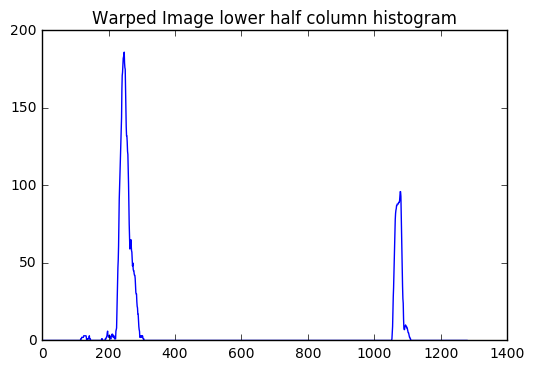

In [228]:
# %% Detect lane pixels and fit to find the lane boundary
# we first take a histogram along all the columns in the lower half of the image
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)
plt.title('Warped Image lower half column histogram')
# plt.savefig('output_images/warped_histogram.jpg')

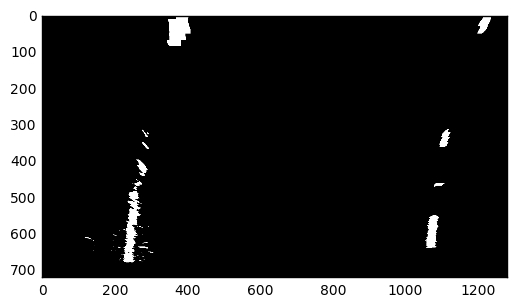

In [229]:
## implement sliding windows and fit a polynomial

# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))#*255

# convert image to integer arrays
out_img = out_img.astype(np.int8)

plt.imshow(out_img)

In [230]:
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 

    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)


# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# change the colour of nonzero pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]



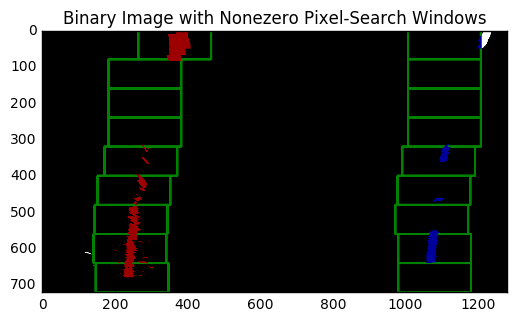

In [231]:
plt.imshow(out_img)
plt.title('Binary Image with Nonezero Pixel-Search Windows')
# plt.savefig('output_images/window_on_bin_image.jpg')

In [232]:
# Skip the sliding windows step once you know where the lines are

test_im_2 = mpimg.imread('test_images/test6.jpg')
binary_warped = transform_n_warp(test_im_2, M)

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

<type 'tuple'>


In [233]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))#*255
window_img = np.zeros_like(out_img)

In [234]:
# # convert image to integer arrays
# out_img = out_img.astype(np.int8)
# window_img = window_img.astype(np.int8)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]

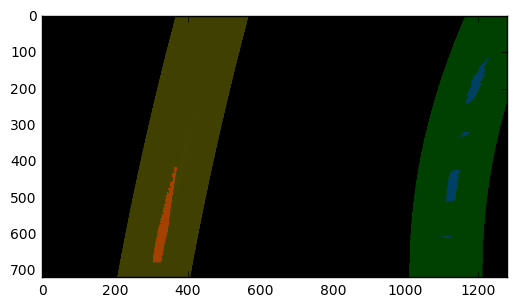

In [235]:
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

# out_img = out_img.astype(np.int8)
result = cv2.addWeighted(out_img, 1, window_img, 0.25, 0)
plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

Determine the curvature of the lane and vehicle position with respect to center

In [236]:
# %% Determine the curvature of the lane and vehicle position with respect to center

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

(9169.0919800087431, 1593.8137446442668)


In [ ]:
## So here's a way to repeat the calculation of radius of curvature after correcting for scale in x and y:

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720.0 # meters per pixel in y dimension
xm_per_pix = 3.7/700.0 # meters per pixel in x dimension

# # Fit a second order polynomial to each
# left_fit = np.polyfit(lefty, leftx, 2)
# right_fit = np.polyfit(righty, rightx, 2)

# # Fit new polynomials to x,y in world space
# left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

# # Fit a second order polynomial to each
# left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

In [ ]:
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

Warp the detected lane boundaries back onto the original image

In [ ]:
# %% Warp the detected lane boundaries back onto the original image
# # Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(result, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(result, Minv, (img_size[0], img_size[1])) 

newwarp = np.uint8(newwarp)

# Combine the result with the original image
final = cv2.addWeighted(test_im_2, 1, newwarp, 0.5, 0)
plt.imshow(final)

Output visual display of the lane boundaries and numerical estimation of the lane curvature and vehicle position

In [ ]:
img_size[1]

In [ ]:
# %% Output visual display of the lane boundaries and numerical estimation of the lane curvature and vehicle position

# calculate lane midpoint
# left line intercept on x axis
left_intcpt = left_fit[0]*img_size[1]**2 + left_fit[1]*img_size[1] + left_fit[2]

# right line intercept on x axis
right_intcpt = right_fit[0]*img_size[1]**2 + right_fit[1]*img_size[1] + right_fit[2]

lane_mid = (left_intcpt + right_intcpt)/2.0

car_off = lane_mid - img_size[0]/2.0

# convert to meters
car_off *= xm_per_pix


# create display texts on image
font = cv2.FONT_HERSHEY_COMPLEX
curve_disp_txt = 'Curvature: Right = ' + str(np.round(right_curverad,2)) + 'm, Left = ' + str(np.round(left_curverad,2)) + 'm' 

off_disp_txt = 'Car off by ' + str(np.round(car_off,2)) + 'm'

cv2.putText(final, curve_disp_txt, (30, 60), font, 1, (0,0,0), 2)
cv2.putText(final, off_disp_txt, (30, 90), font, 1, (0,0,0), 2)

plt.imshow(final)


In [255]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # flag for new line
        self.new_line = True
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.ploty = []
        
        # camera parameters
        self.dst = np.loadtxt('cam_dist.txt')
        self.mtx = np.loadtxt('cam_mtx.txt')
#         self.src_points = np.float32([[275,673],
#                          [595,449],
#                          [686,449],
#                          [1035,673]])
#         self.dst_points = np.float32([[275,673],
#                                  [275,0],
#                                  [1035,0],
#                                  [1035,673]])
        self.src_points = np.float32([[281,674],
                         [587,455],
                         [697,455],
                         [1040,674]])
        self.dst_points = np.float32([[281,674],
                         [281,0],
                         [1040,0],
                         [1040,674]])
        self.M = np.loadtxt('M_mat.txt')
        self.Minv = np.loadtxt('Minv_mat.txt')
        
        # windows
        # Set the width of the windows +/- margin
        self.margin = 50

        # Set minimum number of pixels found to recenter window
        self.minpix = 100
        
        # Conversions in x and y from pixels space to meters
        self.ym_per_pix = 30/720.0 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
        
    def thresh_bin_im(self, image, s_thresh=(150, 255), sxl_thresh=(15, 255), sxr_thresh=(20, 255), kernel=3):
        """
        Return the colour thresholds binary for L, S and R channels in an image
        img: RGB image
        s_thresh: S channel threshold
        sxl_thresh: sobel x threshold for L channel
        sxr_thresh: sobel x threshold for R channel
        """

#         # Convert to HSL color space and separate L and S channels
#         hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
#         l_channel = hls[:,:,1]
#         s_channel = hls[:,:,2]

#         # from observation, R channel also gives a good result on lane lines
#         r_channel = img[:,:,0]

#         # Sobel x on L channel
#         l_channel[(s_channel >= 85) & (s_channel <= 255)] = 1 # hard thresholding based on observation
#         sobelx_l = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=kernel) # sobel derivative
#         abs_sobelx_l = np.absolute(sobelx_l) # Absolute x derivative to accentuate lines away from horizontal
#         scaled_sxl = np.uint8(255*abs_sobelx_l/np.max(abs_sobelx_l))

#         sxlbinary = np.zeros_like(scaled_sxl) # Threshold x gradient
#         sxlbinary[(scaled_sxl >= sxl_thresh[0]) & (scaled_sxl <= sxl_thresh[1])] = 1

#         # sobel x on R channel
#         r_channel[(r_channel >= 170) & (r_channel <= 240)] = 1
#         sobelx_r = cv2.Sobel(r_channel, cv2.CV_64F, 1, 0, ksize=kernel)
#         abs_sobelx_r = np.absolute(sobelx_r)
#         scaled_sxr = np.uint8(255*abs_sobelx_r/np.max(abs_sobelx_r))

#         sxrbinary = np.zeros_like(scaled_sxr) # Threshold x gradient
#         sxrbinary[(scaled_sxr >= sxr_thresh[0]) & (scaled_sxr <= sxr_thresh[1])] = 1

#         # Threshold S color channel
#         s_binary = np.zeros_like(s_channel)
#         s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

#         # empty channel
#         empty = np.zeros_like(s_channel)

#         # Stack each channel
#         color_binary = np.dstack((s_binary, sxlbinary, empty ))

#         return color_binary
        def bin_it(image, threshold):
            output_bin = np.zeros_like(image)
            output_bin[(image >= threshold[0]) & (image <= threshold[1])]=1
            return output_bin

        hls_im = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

        bin_thresh = [10, 255]
        # rgb threshold for yellow
        lower = np.array([230,180,20],dtype = "uint8")
        upper = np.array([255, 255, 255],dtype = "uint8")
        mask = cv2.inRange(image, lower, upper)
        rgb_y = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8)
        rgb_y = cv2.cvtColor(rgb_y, cv2.COLOR_RGB2GRAY)
        rgb_y = bin_it(rgb_y, bin_thresh)


        # rgb for white (best)
        lower = np.array([100,100,200],dtype = "uint8")
        upper = np.array([255, 255, 255],dtype = "uint8")
        mask = cv2.inRange(image, lower, upper)
        rgb_w = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8)
        rgb_w = cv2.cvtColor(rgb_w, cv2.COLOR_RGB2GRAY)
        rgb_w = bin_it(rgb_w, bin_thresh)


        # hls yellow
        lower = np.array([20,50,30],dtype = "uint8")
        upper = np.array([45, 200, 255],dtype = "uint8")
        mask = cv2.inRange(hls_im, lower, upper)
        hls_y = cv2.bitwise_and(hls_im, hls_im, mask = mask).astype(np.uint8)
    #     hls_y = cv2.cvtColor(hls_y, cv2.COLOR_HLS2BGR)
        hls_y = cv2.cvtColor(hls_y, cv2.COLOR_RGB2GRAY)
        hls_y = bin_it(hls_y, bin_thresh)

        im_bin = np.zeros_like(rgb_y).astype(np.uint8)
        im_bin [(hls_y == 1)|(rgb_w==1)|(rgb_y==1)]= 1
        
        return im_bin
    
    def bin_image(self, image):
        """
        convert colour binary image into a single channel binary image
        image: array with 3 channels
        return binary image with 1 channel which is a bitwise or operation of the original colour channels
        """
        binary = np.zeros_like(image[:,:,1])
        binary[(image[:,:,0] == 1) | (image[:,:,1]==1) |(image[:,:,2]==1)] = 1
        return binary
    
    def transform_n_warp(self, image, M):
        """
        apply transforms to image and warp the image according to transformation matrix
        image: image to be transformed
        M: transformation matrix
        """
        # image size
        img_size = image.shape[:2][::-1]

        # warp image
        image = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

        # convert to coloured binary image
        image = self.thresh_bin_im(image, s_thresh=(150, 255), sxl_thresh=(15, 255), sxr_thresh=(20, 255), kernel=3)

        # convert to 1 channel binary image
#         image = bin_image(image)

        return image
    def update_fit(self, left_fit, right_fit, patience=6):
        """
        update the fit values for n iterations
        """
        self.current_fit = [left_fit, right_fit]
        self.recent_xfitted.append(self.current_fit)
        if len(self.recent_xfitted) > patience:
            self.recent_xfitted.pop(0)
        
        # calculate best fit, mean of last n iterations determined by patience
        self.best_fit = np.mean(self.recent_xfitted, axis=0)
        
        return self.best_fit
        
    
    # find lane function, with sliding window approach
    def find_lane(self, warped):
        """
        return image with lane lines using sliding window approach
        warped: image in bird's eye view
        """
        # check if there is a previous line
#         if self.detected:
#             self.new_line = False

        # Set the width of the windows +/- margin
        margin = self.margin

        # Set minimum number of pixels found to recenter window
        minpix = self.minpix
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((warped, warped, warped)).astype(np.int8)#*255
        window_img = np.zeros_like(out_img)
        
        if self.new_line:
            # we first take a histogram along all the columns in the lower half of the image
            histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)

            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Number of sliding windows
            nwindows = 9

            # Height of windows
            window_height = np.int(warped.shape[0]/nwindows)

            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base


            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = warped.shape[0] - (window+1)*window_height
                win_y_high = warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin


#                 # Draw the windows on the visualization image (not necessary here)
#                 cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
#                 cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 

                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]


                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            self.new_line = False
            
        else:
            nonzero = warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            left_fit, right_fit = self.best_fit
            
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # update global left and right fits
        left_fit, right_fit = self.update_fit(left_fit, right_fit)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
        
        # save ploty
        self.ploty = ploty
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # change the colour of nonzero pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Define y-value where we want radius of curvature
        # We choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)
        
#         left_fit, right_fit = self.best_fit
#         left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#         right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*self.ym_per_pix, left_fitx*self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*self.ym_per_pix, right_fitx*self.xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

        # out_img = out_img.astype(np.int8)
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)        
        
        # %% Warp the detected lane boundaries back onto the original image
        # # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(result, np.int_([pts]), (0,255, 0))
        

        return result, left_curverad, right_curverad

    def pipeline(self, frame):
        """ 
        perform all advanced lane finding process on frame        
        and return processed frame
        """
        # smooth the image using gaussian blur
        frame = cv2.medianBlur(frame,3)
        
        # undistort frame
        frame = cv2.undistort(frame, self.mtx, self.dst, None, self.mtx)
        
        
        
        original_frame = np.copy(frame)
        
        # transform image to bird's eye view
        frame = self.transform_n_warp(frame, self.M)
        
        # find lane lines 
        # Check that there is new line
        # Then check that new line detections makes sense, 
        # i.e., expected curvature, separation, and parallel.
        frame, left_curverad, right_curverad = self.find_lane(frame)
        
#         print abs(left_curverad - right_curverad)
        
        img_size = (frame.shape[:2][0], frame.shape[:2][1])
        
#         # Warp the blank back to original image space using inverse perspective matrix (Minv)
#         newwarp = cv2.warpPerspective(frame.astype(np.float32), self.Minv, img_size[::-1]) 
#         newwarp = np.uint8(newwarp)

#         # Combine the result with the original image
#         frame = cv2.addWeighted(original_frame, 1, newwarp, 0.5, 0)
        
        # display visuals on frame
        
        # return processed frame
        ret_frame = frame
        return ret_frame.astype(np.uint8)

from moviepy.editor import VideoFileClip
frame_line = Line()
vid_output = 'project_solve_rb_2.mp4'
clip_source = VideoFileClip("project_video.mp4")
vid_clip = clip_source.fl_image(frame_line.pipeline) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_solve_rb_2.mp4
[MoviePy] Writing video project_solve_rb_2.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:04<00:00, 10.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_solve_rb_2.mp4 

Wall time: 2min 4s
